# Proovedores de Internet en Argentina 

> Análisis de las quejas realizadas por usuarios de Twitter hacia los distintos proveedores de internet de la República Argentina. Todo este análisis se realiza con el fin de poder derterminar cual es el que tiene menos quejas en relación con la cantidad de clientes.

### Primero realizamos la conexión entre Python y SQL Server 

In [2]:
import pyodbc
import sqlalchemy as sal
from sqlalchemy import create_engine
import pandas as pd
server = 'hxsqldev02\sql2016'
database = 'Academy_Dev_Data_RFlor'
driver = 'SQL Server'
engine = sal.create_engine(f'mssql://{server}/{database}?driver={driver}')
conn = engine.connect()
print(engine.table_names())

<ipython-input-2-674a419c6e52>:10: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  print(engine.table_names())


['dim_dates', 'dim_times', 'dim_users', 'dim_wifi_providers', 'fact_quotes', 'fact_replies', 'fact_retweets', 'fact_tweets', 'locations', 'raw_tweets', 'severity_data', 'trips']


### Empresas con mayor presencia en el mercado

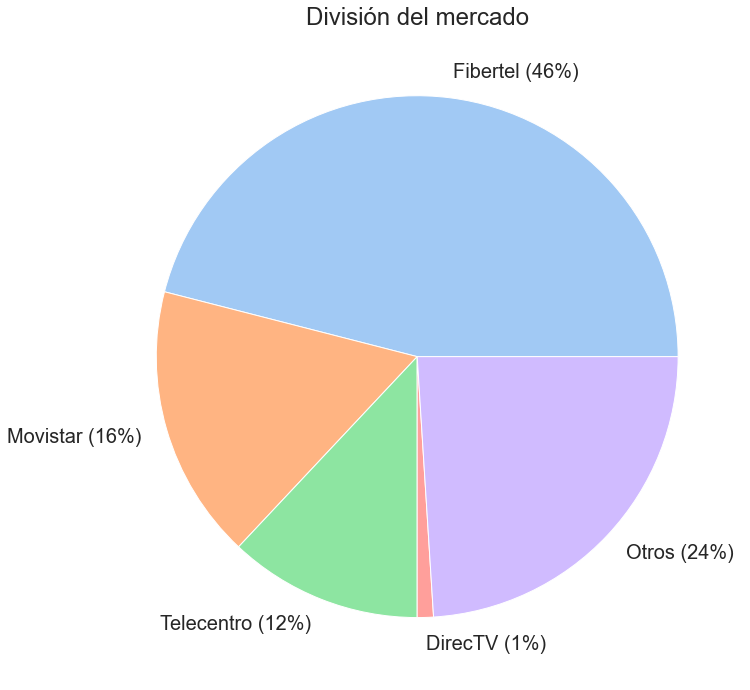

In [22]:
#Piechart de division del mercado

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,12))
mercado=[0.46, 0.17, 0.12, 0.01, 0.24]
empresas = ['Fibertel (46%)', 'Movistar (16%)', 'Telecentro (12%)', 'DirecTV (1%)', 'Otros (24%)']

#Elegimos una paleta y creo el piechart
sns.set_palette("pastel")
plt.title('División del mercado', fontsize=24)
plt.pie(mercado, labels=empresas, labeldistance=1.1, textprops={'fontsize': 20})
plt.show()



 


> Como se nota, hay 3 empresas que copan la mayoría del mercercado. Luego en la sección de 'otros' se encuentran empresas que trabajan en sectores puntuales y no vienen al caso de nuestro análisis.

>La fuente de los datos de porcentaje de mercado es de un informe de CABASE del año 2019, y del total de acceso a internet de un informe del INDEC.

>https://www.cabase.org.ar/wp-content/uploads/2019/12/CABASE-Internet-Index-II-Semestre-2019.pdf
>https://www.indec.gob.ar/uploads/informesdeprensa/internet_06_2134513C3A01.pdf

### Aplicación de NLTK

> Realizamos un análisis de severidad de las quejas realizadas por los usuarios para intentar conocer un poco más el grado de enojo de los mismos. 

>Esto lo hacemos a través del uso de  NLTK, la cual es un conjunto de bibliotecas y programas para el procesamiento del lenguaje natural (PLN) simbólico y estadísticos para Python.

In [8]:
#import nltk
#nltk.downloader.download('vader_lexicon')
from sqlalchemy import create_engine
from nltk.sentiment.vader import SentimentIntensityAnalyzer


# Obtengo a partir de los datos de la BD la información de todos los tweets,  quotes y replies para poder
# analizar la severidad de cada uno.
df_replies = pd.read_sql_query('SELECT * FROM fact_replies JOIN dim_wifi_providers dwp on fact_replies.rp_wifi_provider = dwp.wp_id', engine)
df_quotes = pd.read_sql_query('SELECT * FROM fact_quotes JOIN dim_wifi_providers dwp on fact_quotes.qu_wifi_provider = dwp.wp_id', engine)
df_tweets = pd.read_sql_query('SELECT * FROM fact_tweets JOIN dim_wifi_providers dwp on dwp.wp_id = fact_tweets.tw_wifi_provider', engine)

# Instancio al SentimentIntensityAnalyzer que me permite calcular la severidad
sia = SentimentIntensityAnalyzer()

# Aplico la función a cada dataframe
df_tweets['severity'] = df_tweets.apply(lambda row: sia.polarity_scores(str(row.tw_text))['compound'], axis=1)
df_replies['severity'] = df_replies.apply(lambda row: sia.polarity_scores(str(row.rp_text))['compound'], axis=1)
df_quotes['severity'] = df_quotes.apply(lambda row: sia.polarity_scores(str(row.qu_text))['compound'], axis=1)

# Creo un dataframe que concentre toda la información
df_severity = pd.DataFrame(columns=['wp_name', 'severity'])
df_severity = df_severity.append(df_tweets[['wp_name', 'severity']])
df_severity = df_severity.append(df_replies[['wp_name', 'severity']])
df_severity = df_severity.append(df_quotes[['wp_name', 'severity']])

# Droppeo los que sean mayores iguales a 0
index_names = df_severity[df_severity['severity'] >= 0].index

df_severity.drop(index_names, inplace=True)

# Agrupo el dataframe por empresa y calculo el promedio
df_severity = (df_severity.groupby(by="wp_name", dropna=True).mean())*-1

print(df_severity)

            severity
wp_name             
Claro       0.411652
DirecTV     0.419478
Fibertel    0.497212
Gigared     0.343646
Iplan       0.456167
Iptel       0.645900
Movistar    0.477259
Sion        0.436925
Telecentro  0.459066


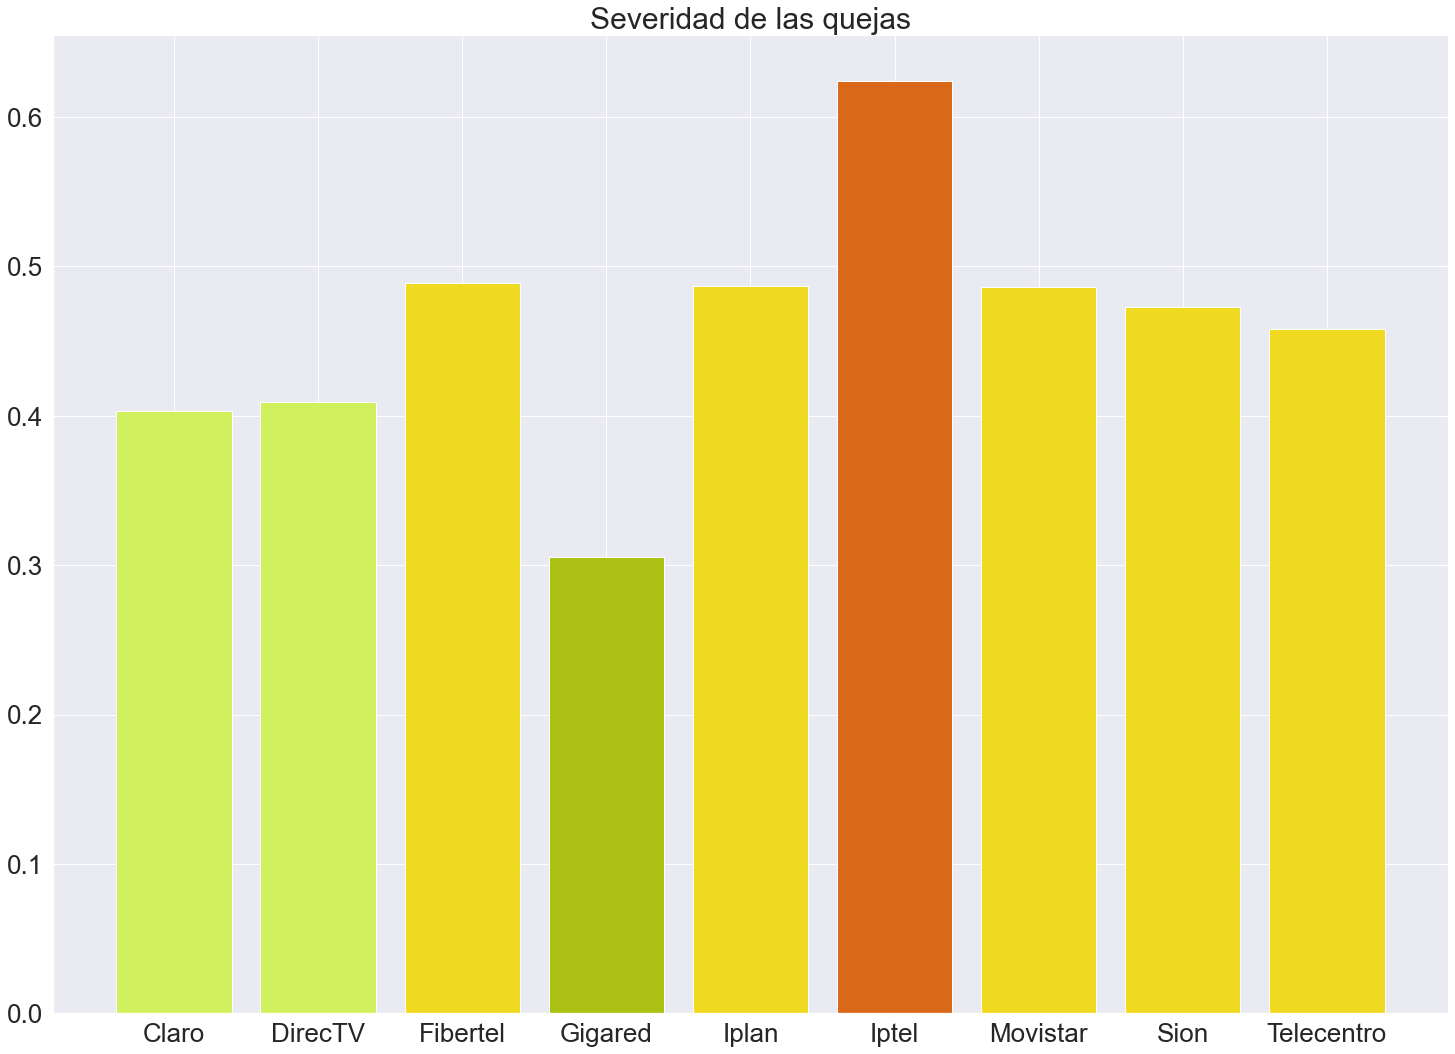

In [55]:
#Grafico de severidad

empresa = ['Claro','DirecTV', 'Fibertel', 'Gigared', 'Iplan', 'Iptel', 'Movistar', 'Sion', 'Telecentro']
severity = df_severity['severity']

#Escalamos colores para hacer notar la severidad
plt.figure(figsize=(25,18))
plt.bar(empresa, df_severity['severity'], color=['#D0F05D', '#D0F05D', '#F0D921', '#ABC215', '#F0D921',
                                                 '#D96918', '#F0D921', '#F0D921', '#F0D921'])

plt.title('Severidad de las quejas', fontsize=30)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.show()

>Podemos observar que las quejas hacia las 3 más grandes tienen una severidad relativamente similar, en cambio con Iptel parece haber un poco más de ensañamiento. Igualmente no debemos olvidar que Iptel tiene muy pocas que quejas y clientes.

### Cantidad de quejas por empresa en este momento

In [12]:
df_totales = pd.read_sql_query("""SELECT 
                                        wp_name as 'nombre',
                                        (SELECT COUNT(*) FROM dbo.fact_tweets where tw_wifi_provider = wp_id) as 'cant_tweets',
                                        (SELECT COUNT(*) FROM dbo.fact_retweets where rt_wifi_provider = wp_id) as 'cant_rts',
                                        (SELECT COUNT(*) FROM dbo.fact_quotes where qu_wifi_provider = wp_id) as 'cant_quotes',
                                        (SELECT COUNT(*) FROM dbo.fact_replies where rp_wifi_provider = wp_id) as 'cant_replies'
                                  FROM dbo.dim_wifi_providers
                                  ORDER BY 1 """, engine)

#Total de gente con acceso a internet segun el INDEC
total = 7248280

df_totales.loc[df_totales.index[2], 'cant_usuarios'] = fib_tot = 0.46*total
df_totales.loc[df_totales.index[1], 'cant_usuarios'] = fib_tot = 0.01*total
df_totales.loc[df_totales.index[7], 'cant_usuarios'] = fib_tot = 0.17*total
df_totales.loc[df_totales.index[9], 'cant_usuarios'] = fib_tot = 0.12*total

df_totales['total'] = df_totales.apply(lambda row: row.cant_tweets + row.cant_replies + row.cant_quotes + row.cant_rts,axis=1)
df_totales.sort_values(by=['total'], ascending=False, inplace=True) #Ordenamos de mayor a menor
df_totales['porcentaje'] = (df_totales['total']/df_totales['cant_usuarios'])*100


print(df_totales)

       nombre  cant_tweets  cant_rts  cant_quotes  cant_replies  \
2    Fibertel         5271      1548          316          3478   
7    Movistar         1908      3801          566          2334   
9  Telecentro         2014       487           95          2454   
0       Claro          320       312           23           596   
1     DirecTV          123        12            3           123   
3     Gigared           98        28            9             6   
4       Iplan           19         5            0            11   
5       Iptel            6         0            0            10   
8        Sion            8         0            0             5   
6    Metrotel            4         1            0             0   

   cant_usuarios  total  porcentaje  
2      3334208.8  10613    0.318306  
7      1232207.6   8609    0.698665  
9       869793.6   5050    0.580598  
0            NaN   1251         NaN  
1        72482.8    261    0.360085  
3            NaN    141         Na

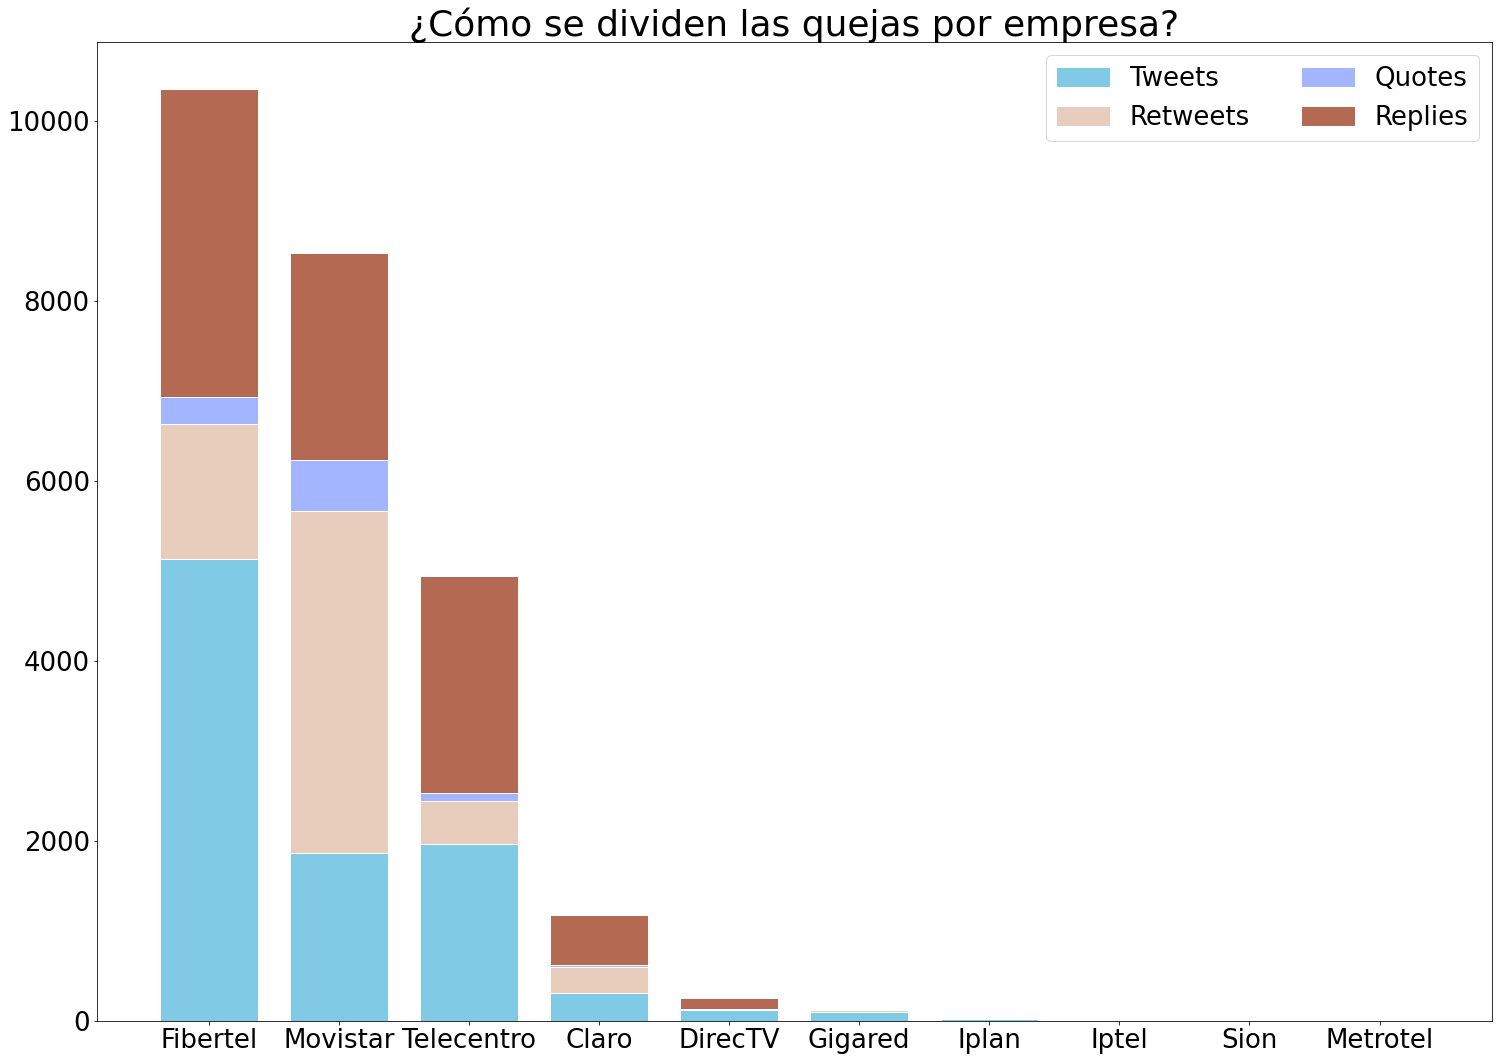

In [8]:
#Grafico de division de quejas

from matplotlib import rc
import matplotlib.patches as mpatches
import numpy as np

barWidth = 0.75
names = df_totales['nombre']
tw = df_totales['cant_tweets']
rt = df_totales['cant_rts']
qu = df_totales['cant_quotes']
re = df_totales['cant_replies']

plt.figure(figsize=(25,18))

# Creamos Tweets Bars
plt.bar(names, tw, color='#81CAE6', edgecolor='white', width=barWidth)
# Creamos Rts Bars
plt.bar(names, rt, bottom=tw, color='#E9CDBC', edgecolor='white', width=barWidth)
# Creamos Quotes Bars
plt.bar(names, qu, bottom=[i+j for i,j in zip(tw, rt)], color='#A3B5FF', edgecolor='white', width=barWidth)
# Creamos Replies Bars
plt.bar(names, re, bottom=[i+j+k for i,j,k in zip(tw, rt, qu)], color='#B36952', edgecolor='white', width=barWidth)

plt.title('¿Cómo se dividen las quejas por empresa?', fontsize=36)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
tw_bar = mpatches.Patch(color='#81CAE6', label='Tweets')
rt_bar = mpatches.Patch(color='#E9CDBC', label='Retweets')
qu_bar = mpatches.Patch(color='#A3B5FF', label='Quotes')
re_bar = mpatches.Patch(color='#B36952', label='Replies')
plt.legend(handles=[tw_bar, rt_bar, qu_bar, re_bar],loc='upper right', ncol=2, fontsize=26)
plt.show()


>Notamos que Fibertel, Movistar y Telecentro acaparan la mayor parte de las quejas. Sim embargo esto puede no ser muy informativo sin antes compararlo con la cantidad de clientes

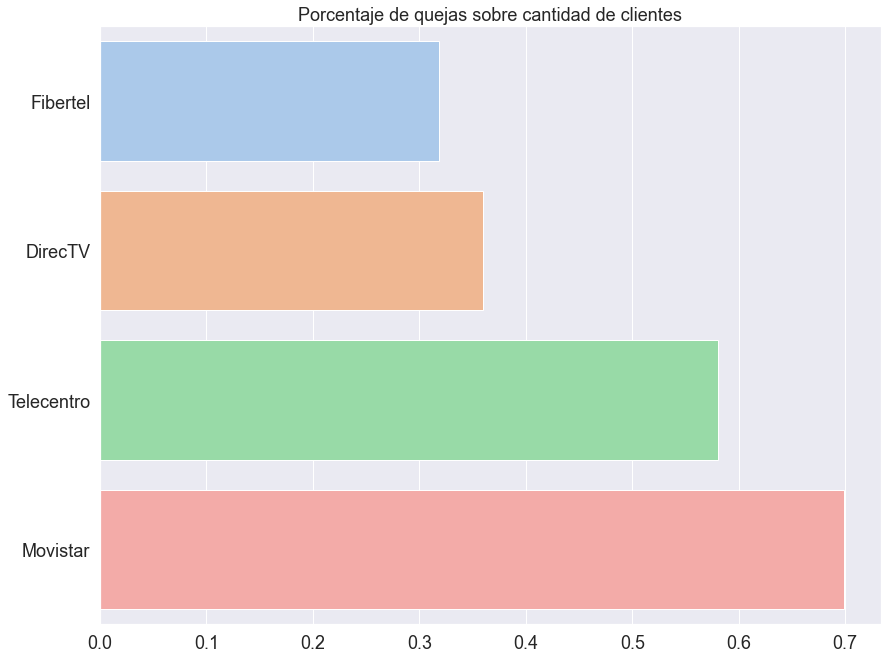

In [31]:
#Grafico de quejas/clientes

import seaborn as sns

empresas_ut =  [df_totales['nombre'][2], df_totales['nombre'][1],
                df_totales['nombre'][9],df_totales['nombre'][7]]
porcen_ut = [df_totales['porcentaje'][2], df_totales['porcentaje'][1],
             df_totales['porcentaje'][9],df_totales['porcentaje'][7]]

plt.figure(figsize=(14,11))
sns.set_palette("pastel")

plt.title('Porcentaje de quejas sobre cantidad de clientes', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)



sns.barplot(
    x=porcen_ut, 
    y=empresas_ut, 
    data=df_totales, 
    estimator=sum, 
    ci=None);


>Este gráfico es el que mas nos hace poder determinar una conclusión y decir que FIBERTEL es la empresa con menor cantidad de quejas en relación a los clientes que posee. Porque sí, uno puede decir que más arriba mostramos que es la que mas quejas tiene, pero la pregunta principal era la relación quejas/clientes.

### ¿Hay más quejas en un horario específico? 

>Como algo extra, nos pareció interesante ya que teníamos los datos, el analizar en si hay algún momento específico del dia en dónde la gente se queje más, todo esto separado por empresa.

In [15]:
df_horarios = pd.read_sql_query("""SELECT 
                                        wp_name as 'nombre',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_tweets
                                            JOIN dim_times dt on fact_tweets.tw_time = dt.ti_id
                                            where tw_wifi_provider = wp_id AND ti_hour >= 0 and ti_hour <= 5) as 'cant_madrugada',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_tweets
                                            JOIN dim_times dt on fact_tweets.tw_time = dt.ti_id
                                            where tw_wifi_provider = wp_id AND ti_hour >= 6 and ti_hour <= 12) as 'cant_maniana',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_tweets
                                            JOIN dim_times dt on fact_tweets.tw_time = dt.ti_id
                                            where tw_wifi_provider = wp_id AND ti_hour >= 13 and ti_hour <= 18) as 'cant_tarde',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_tweets
                                            JOIN dim_times dt on fact_tweets.tw_time = dt.ti_id
                                            where tw_wifi_provider = wp_id AND ti_hour >= 19 and ti_hour <= 23) as 'cant_noche'
                                  FROM dbo.dim_wifi_providers
                                  ORDER BY 1 """, engine)

df_rt_horarios = pd.read_sql_query("""SELECT 
                                        wp_name as 'nombre',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_retweets
                                            JOIN dim_times dt on fact_retweets.rt_time = dt.ti_id
                                            where rt_wifi_provider = wp_id AND ti_hour >= 0 and ti_hour <= 5) as 'cant_madrugada',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_retweets
                                            JOIN dim_times dt on fact_retweets.rt_time = dt.ti_id
                                            where rt_wifi_provider = wp_id AND ti_hour >= 6 and ti_hour <= 12) as 'cant_maniana',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_retweets
                                            JOIN dim_times dt on fact_retweets.rt_time = dt.ti_id
                                            where rt_wifi_provider = wp_id AND ti_hour >= 13 and ti_hour <= 18) as 'cant_tarde',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_retweets
                                            JOIN dim_times dt on fact_retweets.rt_time = dt.ti_id
                                            where rt_wifi_provider = wp_id AND ti_hour >= 19 and ti_hour <= 23) as 'cant_noche'
                                  FROM dbo.dim_wifi_providers
                                  ORDER BY 1 """, engine)
df_rt_horarios = pd.read_sql_query("""SELECT 
                                        wp_name as 'nombre',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_retweets
                                            JOIN dim_times dt on fact_retweets.rt_time = dt.ti_id
                                            where rt_wifi_provider = wp_id AND ti_hour >= 0 and ti_hour <= 5) as 'cant_madrugada',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_retweets
                                            JOIN dim_times dt on fact_retweets.rt_time = dt.ti_id
                                            where rt_wifi_provider = wp_id AND ti_hour >= 6 and ti_hour <= 12) as 'cant_maniana',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_retweets
                                            JOIN dim_times dt on fact_retweets.rt_time = dt.ti_id
                                            where rt_wifi_provider = wp_id AND ti_hour >= 13 and ti_hour <= 18) as 'cant_tarde',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_retweets
                                            JOIN dim_times dt on fact_retweets.rt_time = dt.ti_id
                                            where rt_wifi_provider = wp_id AND ti_hour >= 19 and ti_hour <= 23) as 'cant_noche'
                                  FROM dbo.dim_wifi_providers
                                  ORDER BY 1 """, engine)
df_rp_horarios = pd.read_sql_query("""SELECT 
                                        wp_name as 'nombre',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_replies
                                            JOIN dim_times dt on fact_replies.rp_time = dt.ti_id
                                            where rp_wifi_provider = wp_id AND ti_hour >= 0 and ti_hour <= 5) as 'cant_madrugada',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_replies
                                            JOIN dim_times dt on fact_replies.rp_time = dt.ti_id
                                            where rp_wifi_provider = wp_id AND ti_hour >= 6 and ti_hour <= 12) as 'cant_maniana',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_replies
                                            JOIN dim_times dt on fact_replies.rp_time = dt.ti_id
                                            where rp_wifi_provider = wp_id AND ti_hour >= 13 and ti_hour <= 18) as 'cant_tarde',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_replies
                                            JOIN dim_times dt on fact_replies.rp_time = dt.ti_id
                                            where rp_wifi_provider = wp_id AND ti_hour >= 19 and ti_hour <= 23) as 'cant_noche'
                                  FROM dbo.dim_wifi_providers
                                  ORDER BY 1 """, engine)

df_qu_horarios = pd.read_sql_query("""SELECT 
                                        wp_name as 'nombre',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_quotes
                                            JOIN dim_times dt on fact_quotes.qu_time = dt.ti_id
                                            where qu_wifi_provider = wp_id AND ti_hour >= 0 and ti_hour <= 5) as 'cant_madrugada',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_quotes
                                            JOIN dim_times dt on fact_quotes.qu_time = dt.ti_id
                                            where qu_wifi_provider = wp_id AND ti_hour >= 6 and ti_hour <= 12) as 'cant_maniana',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_quotes
                                            JOIN dim_times dt on fact_quotes.qu_time = dt.ti_id
                                            where qu_wifi_provider = wp_id AND ti_hour >= 13 and ti_hour <= 18) as 'cant_tarde',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_quotes
                                            JOIN dim_times dt on fact_quotes.qu_time = dt.ti_id
                                            where qu_wifi_provider = wp_id AND ti_hour >= 19 and ti_hour <= 23) as 'cant_noche'
                                  FROM dbo.dim_wifi_providers
                                  ORDER BY 1 """, engine)


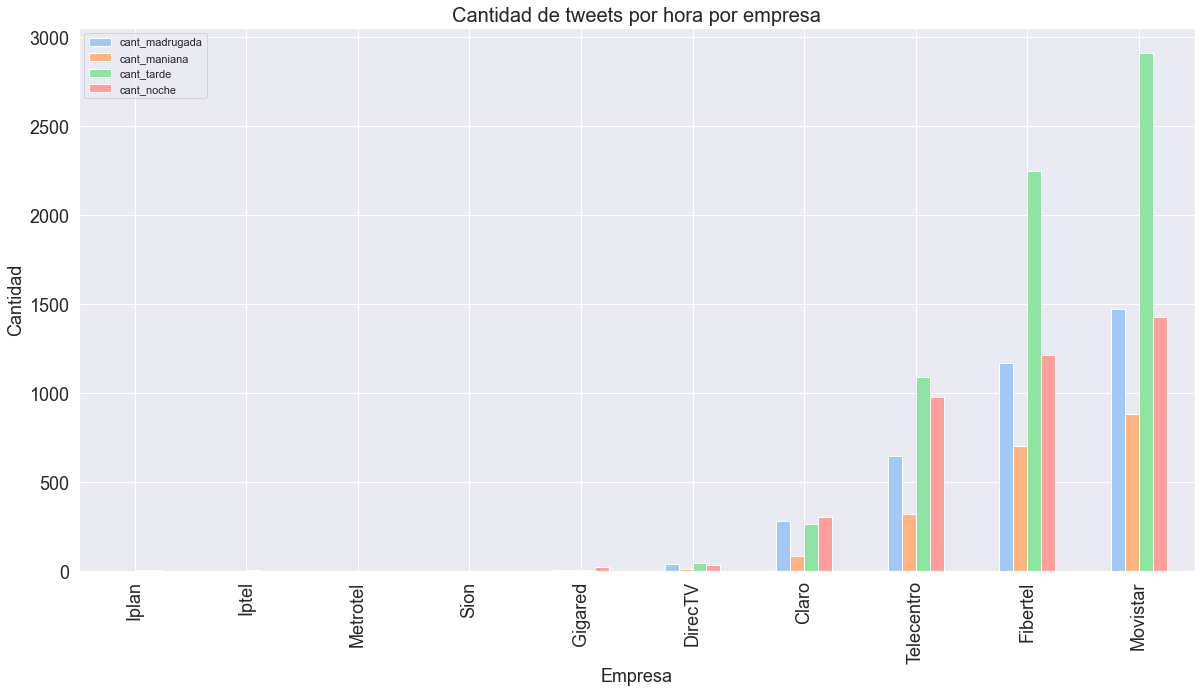

In [25]:
#Grafico de los horarios

df_horarios = df_horarios.append(df_rt_horarios)
df_horarios = df_horarios.append(df_rp_horarios)
df_horarios = df_horarios.append(df_qu_horarios)
df_horarios = df_horarios.groupby(by='nombre').sum()

sns.set_palette("pastel")
#sns.set(style="darkgrid")
df_horarios.sort_values('cant_madrugada',inplace=True)

df_horarios.plot(kind='bar',
             stacked=False,
             figsize=(20, 10))

plt.title('Cantidad de tweets por hora por empresa', fontsize=20)
plt.xlabel('Empresa', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Cantidad', fontsize=18)

plt.show()